# Uncertain Volatility Model 1D

The price of a vanilla payoff $g(X_T)$ on a single asset $X_t$ in the uncertain volatility model satisfies the
one dimensional Black-Scholes-Barenblatt (BSB) PDE
\begin{align*}
\partial_tu(t,x)+\frac{1}{2}x^2\partial_x^2u(t,x)\Sigma\left(\partial_x^2u(t,x)\right)^2&=0\\
u(T,x)&=g(x)
\end{align*}
where
$$
\Sigma(\Gamma)
=
\begin{cases}
\underline{\sigma}, & \Gamma < 0,\\
\overline{\sigma}, & \Gamma \ge 0.
\end{cases}
$$
For the sake of simplicity, we assume zero interest rate and zero dividend and repo.

The BSB PDE is a fully nonlinear second order parabolic PDE which has a stochastic representation by second-oder BSDE. We are free to choose the diffusion for $X$; we pick a lognormal dynamics with some constant volatility $\hat\sigma$,

$$dX_t=\hat{\sigma} X_tdW_t$$

Two numerical schemes to solve 2-BSDEs are presented below. We first divide $(0, T)$ into $n$ subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$ and set $\Delta t_i=t_i-t_{i-1}$ and $\Delta W_{t_i} = W_{t_i} - W_{t_{i-1}}$.

<b>Scheme 1</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Z_{t_n}&=g'\left(X_{t_n}\right)\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
Z_{t_{i-1}}&=\frac{1}{\Delta t_i\hat{\sigma} X_{t_{i-1}}}\mathbb{E}_{i-1}\left[Y_{t_i}\Delta W_{t_i}\right]\\
\Gamma_{t_{i-1}}&=\frac{1}{\Delta t_i\hat{\sigma} X_{t_{i-1}}}\mathbb{E}_{i-1}\left[Z_{t_i}\Delta W_{t_i}\right]
\end{align*}

In the second scheme, we introduce explicitly the Malliavin weight for the log-normal diffusion with volatility $\hat{\sigma}$, so that $\Gamma$ can be estimated directly from $Y$ without computing $Z$ in the intermediate step. In particular, there is no need to compute the final condition $Z_{t_n}=g'\left(X_{t_n}\right)$. This could be useful to handle non-smooth payoffs.

<b>Scheme 2</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
\Gamma_{t_{i-1}}&=\frac{1}{\left(\Delta t_i\hat{\sigma} X_{t_{i-1}}\right)^2}\mathbb{E}_{i-1}\left[Y_{t_i}\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]
\end{align*}

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
from numpy.polynomial import Polynomial
import warnings
warnings.filterwarnings('ignore')

Note: you may need to copy some relevant functions from previous notebooks

In [ ]:
def blackscholes_mc(S=100, vol=0.2, r=0, q=0, ts=np.linspace(0, 1, 13), npaths=10):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    S: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.
    ts: array_like
        The time steps of the simualtion
    npaths: int
        the number of paths to simulate

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    nsteps = len(ts) - 1
    ts = np.asfarray(ts)[:, np.newaxis]
    W = np.cumsum(np.vstack((np.zeros((1, npaths), dtype=float),
                             np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts, axis=0)))),
                  axis=0)
    paths = np.exp(-0.5*vol**2*ts + vol*W)*S*np.exp((r-q)*ts)
    return paths

def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    v = np.sqrt(vol**2*T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

# Exercise

Consider pricing the call spread $\frac{100}{K_2-K_1}\left(\left(X_T-K_1\right)^+-\left(X_T-K_2\right)^+\right)$ in the uncertain volatility model, where

\begin{equation*}
\underline{\sigma}=0.1,\quad\overline{\sigma}=0.2,\quad X_0=100,\quad T=1, \quad K_1 = 90, \quad K_2 = 110
\end{equation*}

For your reference, the true price (from PDE) is $56.0$.

<b>(a).</b> Implement Scheme 1 with $\hat{\sigma}=0.15$, 12 time steps $(\Delta t_1=1/12)$ and 5000 paths. After you obtain estimates of $x\mapsto\Gamma\left(t_i, x\right)$ at each discretization time $t_i$, re-simulate a new set of independent paths following the process $dX_t = \Sigma(\Gamma(t,X_t))X_tdW_t$ to price the call spread, using more time steps (say, 360 $(\Delta t_2=1/360)$), and more paths (say, 50,000). To evaluate $\Gamma(t,X_t)$ at intermediate time step $t$ with $t_i<t<t_{i+1}$, you may use constant interpolation, i.e. $\Gamma(t_i, X_t)$ or $\Gamma(t_{i+1}, X_t)$, or linear interpolation, i.e., $w_t\Gamma(t_i, X_t)+(1-w_t)\Gamma(t_{i+1},X_t)$ with $w_t=(t_{i+1}-t)/(t_{i+1}-t_i)$. 

- Experiment with smaller $\Delta t_1$. Comment on the results.
- Describe the region where the gamma is positive (resp. negative).

<b>(b).</b> Implement Scheme 2 outlined above to price the call spread. As in part (a), after you obtain estimates of $x\mapsto\Gamma\left(t_i, x\right)$ at each discretization time $t_i$, re-simulate a new set of independent paths following the process $dX_t = \Sigma(\Gamma(t,X_t))X_tdW_t$ to price the call spread, using more time steps. Compare the results of the two schemes.

<b>(c).</b> In schemes 1 and 2, the estimations of the conditional expectations for $Z_{t_{i-1}}$ and $\Gamma_{t_{i-1}}$ may suffer large variances when $\Delta t_i$ is small. Control variates can be used to reduce the variance. For example, Scheme 2 can be modified as follows

<b>Scheme 2a</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
\Gamma_{t_{i-1}}&=\frac{1}{\left(\Delta t_i\hat{\sigma} X_{t_{i-1}}\right)^2}\mathbb{E}_{i-1}\left[\left(Y_{t_i}-\mathbb{E}_{i-1}\left[Y_{t_i}\right]\right)\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]
\end{align*}
Note that $Y_{t_i}$ on the right side of the last equation has been replaced by $Y_{t_{i}}-\mathbb{E}_{i-1}\left[Y_{t_i}\right]$.

Explain why this replacement does not change the left hand side. Implement Scheme 2a. Do you observe variance reduction?

# part (a)

In [ ]:
sigma_low = 0.1
sigma_high = 0.2
sigma_hat = 0.15

X0 = 100
T = 1
K1 = 90
K2 = 110

n_steps_1 = 12
n_paths_1 = 5000

n_steps_2 = 360
n_paths_2 = 50000

In [ ]:
np.random.seed(42)

ts_1 = np.linspace(0, T, n_steps_1 + 1)
dt_1 = np.diff(ts_1)

dW_1 = np.random.randn(n_steps_1, n_paths_1) * np.sqrt(dt_1[:, np.newaxis])
W_1 = np.vstack([np.zeros((1, n_paths_1)), np.cumsum(dW_1, axis=0)])

paths_1 = X0 * np.exp(-0.5 * sigma_hat**2 * ts_1[:, np.newaxis] + sigma_hat * W_1)

In [ ]:
def payoff(x):
    return 100 / (K2 - K1) * (np.maximum(x - K1, 0) - np.maximum(x - K2, 0))

def payoff_deriv(x):
    return 100 / (K2 - K1) * ((x > K1).astype(float) - (x > K2).astype(float))

def Sigma(gamma):
    return np.where(gamma >= 0, sigma_high, sigma_low)

def make_get_Gamma(Gamma_polys, n_steps_1_val):
    def get_Gamma(t, x):
        idx = int(t * n_steps_1_val / T)
        idx = min(idx, n_steps_1_val - 1)
        poly = Gamma_polys[idx]
        dt = T / n_steps_1_val
        return poly(x) / (dt * sigma_hat * x)
    return get_Gamma

Y = payoff(paths_1[-1])
Z = payoff_deriv(paths_1[-1])

deg = 5

Gamma_polys = [None] * n_steps_1

for i in range(n_steps_1, 0, -1):
    X_prev = paths_1[i-1]
    dt = dt_1[i-1]
    dW = dW_1[i-1]
    
    poly_Gamma = Polynomial.fit(X_prev, Z * dW, deg)
    Gamma = poly_Gamma(X_prev) / (dt * sigma_hat * X_prev)
    Gamma_polys[i-1] = poly_Gamma

    poly_Z = Polynomial.fit(X_prev, Y * dW, deg)
    Z = poly_Z(X_prev) / (dt * sigma_hat * X_prev)
    
    poly_Y = Polynomial.fit(X_prev, Y, deg)
    E_Y = poly_Y(X_prev)
    Y = E_Y + 0.5 * Gamma * X_prev**2 * (Sigma(Gamma)**2 - sigma_hat**2) * dt

step1_price_s1 = np.mean(Y)

In [ ]:
get_Gamma = make_get_Gamma(Gamma_polys, n_steps_1)

In [ ]:
np.random.seed(123)

dt_2 = T / n_steps_2

paths_2 = np.zeros((n_steps_2 + 1, n_paths_2))
paths_2[0] = X0

for i in range(n_steps_2):
    t = i * dt_2 
    X = paths_2[i]
    
    Gamma = get_Gamma(t, X)
    sigma = Sigma(Gamma)
    
    dW = np.random.randn(n_paths_2) * np.sqrt(dt_2)
    paths_2[i+1] = X * np.exp(-0.5 * sigma**2 * dt_2 + sigma * dW)

In [ ]:
X_T = paths_2[-1]
payoffs = payoff(X_T)

step2_price_s1 = np.mean(payoffs)

print(f"Call Spread price: {step2_price_s1:.4f}")
print(f"true price (PDE): 56.0")
print(f"error: {abs(step2_price_s1 - 56.0):.4f} ({abs(step2_price_s1 - 56.0)/56.0 * 100:.2f}%)")

Call Spread price: 54.4959
true price (PDE): 56.0
error: 1.5041 (2.69%)


In [ ]:
def run_experiment(n_steps_1_val, n_paths_1_val=5000, n_steps_2_val=360, n_paths_2_val=50000, seed=42):
    np.random.seed(seed)
    
    ts_1 = np.linspace(0, T, n_steps_1_val + 1)
    dt_1 = np.diff(ts_1)
    dW_1 = np.random.randn(n_steps_1_val, n_paths_1_val) * np.sqrt(dt_1[:, np.newaxis])
    W_1 = np.vstack([np.zeros((1, n_paths_1_val)), np.cumsum(dW_1, axis=0)])
    paths_1 = X0 * np.exp(-0.5 * sigma_hat**2 * ts_1[:, np.newaxis] + sigma_hat * W_1)
    
    Y = payoff(paths_1[-1])
    Z = payoff_deriv(paths_1[-1])
    Gamma_polys_exp = [None] * n_steps_1_val
    
    for i in range(n_steps_1_val, 0, -1):
        X_prev = paths_1[i-1]
        dt = dt_1[i-1]
        dW = dW_1[i-1]
        
        poly_Gamma = Polynomial.fit(X_prev, Z * dW, deg)
        Gamma = poly_Gamma(X_prev) / (dt * sigma_hat * X_prev)
        Gamma_polys_exp[i-1] = poly_Gamma
        
        poly_Z = Polynomial.fit(X_prev, Y * dW, deg)
        Z = poly_Z(X_prev) / (dt * sigma_hat * X_prev)
        
        poly_Y = Polynomial.fit(X_prev, Y, deg)
        E_Y = poly_Y(X_prev)
        Y = E_Y + 0.5 * Gamma * X_prev**2 * (Sigma(Gamma)**2 - sigma_hat**2) * dt
    
    step1_price = np.mean(Y)
    
    get_Gamma_exp = make_get_Gamma(Gamma_polys_exp, n_steps_1_val)
    
    dt_2 = T / n_steps_2_val
    paths_2 = np.zeros((n_steps_2_val + 1, n_paths_2_val))
    paths_2[0] = X0
    
    for i in range(n_steps_2_val):
        t = i * dt_2
        X = paths_2[i]
        Gamma = get_Gamma_exp(t, X)
        sigma = Sigma(Gamma)
        dW = np.random.randn(n_paths_2_val) * np.sqrt(dt_2)
        paths_2[i+1] = X * np.exp(-0.5 * sigma**2 * dt_2 + sigma * dW)
    
    step2_price = np.mean(payoff(paths_2[-1]))
    
    return step1_price, step2_price

n_steps_list = [6, 12, 24, 48, 96]
results = []

for n in n_steps_list:
    print(f"  n_steps_1 = {n}")
    p1, p2 = run_experiment(n)
    results.append((n, p1, p2))

print("\n" + "="*75)
print(f"{'n_steps_1':>10} | {'Step1 price':>12} | {'Step1 error':>10} | {'Step2 price':>12} | {'Step2 error':>10}")
print("="*75)
for n, p1, p2 in results:
    err1 = abs(p1 - 56.0) / 56.0 * 100
    err2 = abs(p2 - 56.0) / 56.0 * 100
    print(f"{n:>10} | {p1:>12.4f} | {err1:>9.2f}% | {p2:>12.4f} | {err2:>9.2f}%")
print("="*75)
print(f"{'true price':>10} | {56.0:>12.4f} | {'':>10} | {56.0:>12.4f} |")

  n_steps_1 = 6
  n_steps_1 = 12
  n_steps_1 = 24
  n_steps_1 = 48
  n_steps_1 = 96

 n_steps_1 |  Step1 price | Step1 error |  Step2 price | Step2 error
         6 |      54.3021 |      3.03% |      54.8317 |      2.09%
        12 |      56.0051 |      0.01% |      54.2309 |      3.16%
        24 |      57.4046 |      2.51% |      53.6283 |      4.24%
        48 |      61.3115 |      9.48% |      52.5190 |      6.22%
        96 |      70.8266 |     26.48% |      52.1482 |      6.88%
true price |      56.0000 |            |      56.0000 |


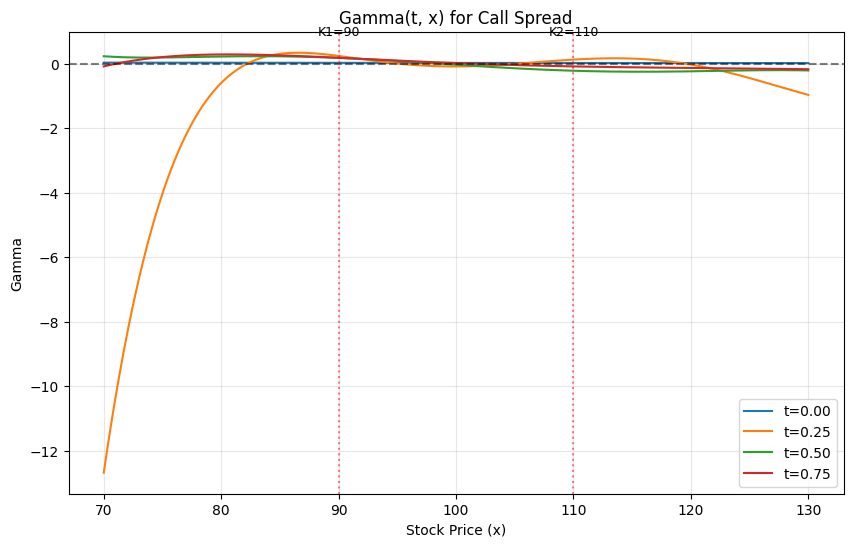

Gamma Region Analysis (at t=0.5)
     x |      Gamma |     Sign |    sigma
------------------------------------------
    75 |     0.1875 | positive |      0.2
    85 |     0.2247 | positive |      0.2
    95 |     0.0820 | positive |      0.2
   100 |    -0.0355 | negative |      0.1
   105 |    -0.1453 | negative |      0.1
   115 |    -0.2520 | negative |      0.1
   125 |    -0.2100 | negative |      0.1


In [ ]:
x_range = np.linspace(70, 130, 200)
t_values = [0.0, 0.25, 0.5, 0.75]

plt.figure(figsize=(10, 6))

for t in t_values:
    gamma_vals = get_Gamma(t, x_range)
    plt.plot(x_range, gamma_vals, label=f't={t:.2f}')

plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axvline(x=K1, color='r', linestyle=':', alpha=0.5)
plt.axvline(x=K2, color='r', linestyle=':', alpha=0.5)
plt.xlabel('Stock Price (x)')
plt.ylabel('Gamma')
plt.title('Gamma(t, x) for Call Spread')
plt.legend()
plt.grid(True, alpha=0.3)
plt.text(K1, plt.ylim()[1]*0.9, f'K1={K1}', ha='center', fontsize=9)
plt.text(K2, plt.ylim()[1]*0.9, f'K2={K2}', ha='center', fontsize=9)
plt.show()

print("=" * 50)
print("Gamma Region Analysis (at t=0.5)")
print("=" * 50)

test_points = [75, 85, 95, 100, 105, 115, 125]
print(f"{'x':>6} | {'Gamma':>10} | {'Sign':>8} | {'sigma':>8}")
print("-" * 42)
for x in test_points:
    g = get_Gamma(0.5, x)
    sign = "positive" if g >= 0 else "negative"
    sigma = sigma_high if g >= 0 else sigma_low
    print(f"{x:>6} | {g:>10.4f} | {sign:>8} | {sigma:>8}")

### Part (a) Discussion

**Δt Experiment:**
As n_steps increases (smaller Δt), the Step1 error increases dramatically (0.01% → 26.48%). This occurs because Z and Γ estimation formulas have Δt in the denominator. When Δt is small, dividing by a small number amplifies the Monte Carlo noise, causing high variance in the estimates. This demonstrates the bias-variance tradeoff: larger Δt gives more bias but lower variance, while smaller Δt gives less bias but higher variance. The optimal choice appears to be around n_steps = 12.

**Gamma Region:**
- x < ~100: Gamma > 0, so the model uses sigma_high = 0.2
- x > ~100: Gamma < 0, so the model uses sigma_low = 0.1

This makes sense because the call spread consists of a long call at K1=90 and a short call at K2=110. Near K1, the long call's positive gamma dominates. Near K2, the short call's negative gamma dominates. The crossover point is around x=100, the midpoint of the two strikes.

# part (b)

In [ ]:
def make_get_Gamma_s2(Gamma_polys, n_steps_1_val):
    def get_Gamma(t, x):
        idx = int(t * n_steps_1_val / T)
        idx = min(idx, n_steps_1_val - 1)
        poly = Gamma_polys[idx]
        dt = T / n_steps_1_val
        return poly(x) / (dt * sigma_hat * x)**2
    return get_Gamma

np.random.seed(42)

ts_1_s2 = np.linspace(0, T, n_steps_1 + 1)
dt_1_s2 = np.diff(ts_1_s2)

dW_1_s2 = np.random.randn(n_steps_1, n_paths_1) * np.sqrt(dt_1_s2[:, np.newaxis])
W_1_s2 = np.vstack([np.zeros((1, n_paths_1)), np.cumsum(dW_1_s2, axis=0)])

paths_1_s2 = X0 * np.exp(-0.5 * sigma_hat**2 * ts_1_s2[:, np.newaxis] + sigma_hat * W_1_s2)

Y_s2 = payoff(paths_1_s2[-1])

Gamma_polys_s2 = [None] * n_steps_1

for i in range(n_steps_1, 0, -1):
    X_prev_s2 = paths_1_s2[i-1]
    dt_s2 = dt_1_s2[i-1]
    dW_s2 = dW_1_s2[i-1]
    
    malliavin_weight = dW_s2**2 - dt_s2 * (1 + sigma_hat * dW_s2)
    
    poly_Gamma_s2 = Polynomial.fit(X_prev_s2, Y_s2 * malliavin_weight, deg)
    Gamma_s2 = poly_Gamma_s2(X_prev_s2) / (dt_s2 * sigma_hat * X_prev_s2)**2
    Gamma_polys_s2[i-1] = poly_Gamma_s2
    
    poly_Y_s2 = Polynomial.fit(X_prev_s2, Y_s2, deg)
    E_Y_s2 = poly_Y_s2(X_prev_s2)
    Y_s2 = E_Y_s2 + 0.5 * Gamma_s2 * X_prev_s2**2 * (Sigma(Gamma_s2)**2 - sigma_hat**2) * dt_s2

get_Gamma_s2 = make_get_Gamma_s2(Gamma_polys_s2, n_steps_1)
step1_price_s2 = np.mean(Y_s2)

In [ ]:
np.random.seed(123)

dt_2_s2 = T / n_steps_2

paths_2_s2 = np.zeros((n_steps_2 + 1, n_paths_2))
paths_2_s2[0] = X0

for i in range(n_steps_2):
    t = i * dt_2_s2
    X = paths_2_s2[i]
    
    Gamma = get_Gamma_s2(t, X)
    sigma = Sigma(Gamma)
    
    dW = np.random.randn(n_paths_2) * np.sqrt(dt_2_s2)
    paths_2_s2[i+1] = X * np.exp(-0.5 * sigma**2 * dt_2_s2 + sigma * dW)

price_s2 = np.mean(payoff(paths_2_s2[-1]))

print(f"Scheme 2 Step 2 price: {price_s2:.4f}")
print(f"True price: 56.0")
print(f"Error: {abs(price_s2 - 56.0) / 56.0 * 100:.2f}%")

Scheme 2 Step 2 price: 53.0153
True price: 56.0
Error: 5.33%


In [ ]:
print("=" * 80)
print("Scheme 1 vs Scheme 2 Comparison")
print("=" * 80)
print(f"{'':>10} | {'Step1 Price':>12} | {'Step1 Error':>11} | {'Step2 Price':>12} | {'Step2 Error':>11}")
print("-" * 80)
print(f"{'Scheme 1':>10} | {step1_price_s1:>12.4f} | {abs(step1_price_s1-56)/56*100:>10.2f}% | {step2_price_s1:>12.4f} | {abs(step2_price_s1-56)/56*100:>10.2f}%")
print(f"{'Scheme 2':>10} | {np.mean(Y_s2):>12.4f} | {abs(np.mean(Y_s2)-56)/56*100:>10.2f}% | {price_s2:>12.4f} | {abs(price_s2-56)/56*100:>10.2f}%")
print("-" * 80)
print(f"{'True Price':>10} | {56.0:>12.4f} | {'':>11} | {56.0:>12.4f} |")
print("=" * 80)

Scheme 1 vs Scheme 2 Comparison
           |  Step1 Price | Step1 Error |  Step2 Price | Step2 Error
--------------------------------------------------------------------------------
  Scheme 1 |      56.0051 |       0.01% |      54.4959 |       2.69%
  Scheme 2 |      66.5002 |      18.75% |      53.0153 |       5.33%
--------------------------------------------------------------------------------
True Price |      56.0000 |             |      56.0000 |


### Part (b) Discussion

**Scheme 1 vs Scheme 2 Comparison:**

Scheme 1 outperforms Scheme 2 in both steps:
- Step1: Scheme 1 error (0.01%) vs Scheme 2 error (18.75%)
- Step2: Scheme 1 error (2.69%) vs Scheme 2 error (5.33%)

Scheme 2 has higher variance because the Malliavin weight term (ΔW² - Δt(1 + σΔW)) has larger variance than the simple ΔW used in Scheme 1. However, Scheme 2 has the advantage of not requiring the payoff derivative g'(x), which can be useful for non-smooth payoffs.

# part (c)

**Why does replacing Y with (Y - E[Y]) not change the result?**

The original Gamma estimator computes E[Y · M], where M is the Malliavin weight.

We can decompose E[Y · M] as:
E[Y · M] = E[(Y - E[Y]) · M] + E[Y] · E[M]

The key observation is that E[M] = 0. This is because:
- E[ΔW²] = Δt
- E[Δt(1 + σΔW)] = Δt(1 + 0) = Δt
- Therefore E[M] = E[ΔW²] - E[Δt(1 + σΔW)] = Δt - Δt = 0

Since E[M] = 0, the second term E[Y] · E[M] = 0, and we have:
E[Y · M] = E[(Y - E[Y]) · M]

In [ ]:
np.random.seed(42)

ts_1_s2a = np.linspace(0, T, n_steps_1 + 1)
dt_1_s2a = np.diff(ts_1_s2a)

dW_1_s2a = np.random.randn(n_steps_1, n_paths_1) * np.sqrt(dt_1_s2a[:, np.newaxis])
W_1_s2a = np.vstack([np.zeros((1, n_paths_1)), np.cumsum(dW_1_s2a, axis=0)])

paths_1_s2a = X0 * np.exp(-0.5 * sigma_hat**2 * ts_1_s2a[:, np.newaxis] + sigma_hat * W_1_s2a)

Y_s2a = payoff(paths_1_s2a[-1])

Gamma_polys_s2a = [None] * n_steps_1

for i in range(n_steps_1, 0, -1):
    X_prev_s2a = paths_1_s2a[i-1]
    dt_s2a = dt_1_s2a[i-1]
    dW_s2a = dW_1_s2a[i-1]
    
    poly_Y_s2a = Polynomial.fit(X_prev_s2a, Y_s2a, deg)
    E_Y_s2a = poly_Y_s2a(X_prev_s2a)
    
    malliavin_weight = dW_s2a**2 - dt_s2a * (1 + sigma_hat * dW_s2a)
    poly_Gamma_s2a = Polynomial.fit(X_prev_s2a, (Y_s2a - E_Y_s2a) * malliavin_weight, deg)
    Gamma_s2a = poly_Gamma_s2a(X_prev_s2a) / (dt_s2a * sigma_hat * X_prev_s2a)**2
    Gamma_polys_s2a[i-1] = poly_Gamma_s2a
    
    Y_s2a = E_Y_s2a + 0.5 * Gamma_s2a * X_prev_s2a**2 * (Sigma(Gamma_s2a)**2 - sigma_hat**2) * dt_s2a

step1_price_s2a = np.mean(Y_s2a)
print(f"Scheme 2a Step 1 price: {step1_price_s2a:.4f}")

Scheme 2a Step 1 price: 55.6138


In [ ]:
true_price = 56.0

s2_price = np.mean(Y_s2)
s2_error = abs(s2_price - true_price) / true_price * 100

s2a_price = step1_price_s2a
s2a_error = abs(s2a_price - true_price) / true_price * 100

print("=" * 60)
print("Scheme 2 vs Scheme 2a Comparison (Step 1)")
print("=" * 60)
print(f"{'':>12} | {'Step1 Price':>12} | {'Step1 Error':>11}")
print("-" * 60)
print(f"{'Scheme 2':>12} | {s2_price:>12.4f} | {s2_error:>10.2f}%")
print(f"{'Scheme 2a':>12} | {s2a_price:>12.4f} | {s2a_error:>10.2f}%")
print("-" * 60)
print(f"{'True Price':>12} | {true_price:>12.4f} |")
print("=" * 60)

Scheme 2 vs Scheme 2a Comparison (Step 1)
             |  Step1 Price | Step1 Error
------------------------------------------------------------
    Scheme 2 |      66.5002 |      18.75%
   Scheme 2a |      55.6138 |       0.69%
------------------------------------------------------------
  True Price |      56.0000 |


**Do we observe variance reduction?**

Yes, significant variance reduction is observed:
- Scheme 2 Step1 Error: 18.75%
- Scheme 2a Step1 Error: 0.69%

This is because centering Y around its mean (Y - E[Y]) removes the large constant component from the product with the Malliavin weight M. Since (Y - E[Y]) fluctuates around zero with smaller magnitude, the product (Y - E[Y]) · M has much lower variance than Y · M. This is the principle of control variates.